In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [44]:
def generate_data():
    n = 30
    x = np.random.random((n,1))
    f_x = 4*np.sin(np.pi*x)*np.cos(6*np.pi*(x**2))
    
    eps = np.random.randn(n,1)
    y = f_x + eps
    return x,y,f_x

def make_K_mat_rbf(x,gamma):
    K = np.zeros((x.shape[0],x.shape[0]))
    
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            K[i][j] = np.exp(-gamma*(np.linalg.norm(x[i]-x[j])))
            
    return K

def make_K_mat_poly(x,d):
    K = np.zeros((x.shape[0],x.shape[0]))

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            terms_to_eval = (1+np.dot(x[i].T,x[j]))
            K[i][j] = terms_to_eval**d
    return K

def kernel_eval_rbf(gamma,x_1,x_2):
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])))
        eval_kernel.append(eval_iter)
    return eval_kernel 

def kernel_eval_poly(d,x_1,x_2):
    
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])))
        eval_kernel.append(eval_iter)
        
    return eval_kernel

def alpha_hat_compute(K,lambda_val,y):
    
    lhs = K + lambda_val*np.identity(np.shape(K)[0])
    alpha_hat = np.linalg.solve(lhs,y)
    
    return alpha_hat

def choose_gamma(x):
    dist_vals = []
    for i in np.arange(x.shape[0]):
        for j in np.arange(i):
            dist_vals.append((np.linalg.norm(x[i] - x[j])))
            
    median_val = np.median(np.array(dist_vals))
    gamma = 1/median_val
    return gamma,dist_vals

def f_hat_compute(K,alpha_hat):
    f_hat = np.dot(alpha_hat,K)
    
    return f_hat

def LOOCV_rbf(x,y,lambda_vec):
    
    cost_vec = []
    gamma_vec = []
    
    for lambda_val in lambda_vec:
            score_ind = []
            gamma_ind = []
            
            for valid_ind in np.arange(y.shape[0]):
                mask = np.ones(np.shape(y))
                mask[valid_ind] = 0
                mask = mask.astype('bool')
                y_train = y[mask]
                y_test = y[valid_ind]
                x_train = x[mask]
                x_test = x[valid_ind]
                
                gamma,dist_vals = choose_gamma(x_train)
                K = make_K_mat_rbf(x_train,gamma)
                alpha_hat = alpha_hat_compute(K,lambda_val,y_train)
                f_hat = f_hat_compute(alpha_hat,K)
                
                #w_vec = np.dot(x_train,alpha_hat)
                #predict_y = np.dot(w_vec,x_test)
                
                eval_kernel = kernel_eval_rbf(gamma,x_test,x_train)
                predict_y = np.array([np.sum(alpha_hat*eval_kernel)])
                #import pdb;pdb.set_trace()
                cost_ind = cost_func(predict_y,y_test)
                gamma_ind.append(gamma)
                score_ind.append(cost_ind)
                #import pdb;pdb.set_trace()


            score = (1/len(score_ind))*np.sum(score_ind)
            gamma_vec.append((1/len(score_ind))*np.sum(gamma_ind))
            
            cost_vec.append(score)
    
    return cost_vec,gamma_vec

def LOOCV_poly(x,y):
    
    cost_vec = []
    lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
    d_vec = np.arange(1,30,3)

    for lambda_val in lambda_vec:
            score_over_lambda = []
            gamma_over_lambda  = []
        for d_ind in d_vec:

            for valid_ind in np.arange(y.shape[0]):
                mask = np.ones(np.shape(y))
                mask[valid_ind] = 0
                mask = mask.astype('bool')
                y_train = y[mask]
                y_test = y[valid_ind]
                x_train = x[mask]
                x_test = x[valid_ind]

                gamma,dist_vals = choose_gamma(x_train)
                K = make_K_mat_rbf(x_train,gamma)
                alpha_hat = alpha_hat_compute(K,lambda_val,y_train)
                f_hat = f_hat_compute(alpha_hat,K)

                #w_vec = np.dot(x_train,alpha_hat)
                #predict_y = np.dot(w_vec,x_test)

                eval_kernel = kernel_eval_rbf(gamma,x_test,x_train)
                predict_y = np.array([np.sum(alpha_hat*eval_kernel)])
                #import pdb;pdb.set_trace()
                cost_ind = cost_func(predict_y,y_test)
                gamma_ind.append(gamma)
                score_ind.append(cost_ind)
                #import pdb;pdb.set_trace()


            score = (1/len(score_ind))*np.sum(score_ind)
            gamma_vec.append((1/len(score_ind))*np.sum(gamma_ind))

            cost_vec.append(score)
    
    return cost_vec,d_vec

def cost_func(prediction,truth):
    
    cost = []
    
    for i in np.arange(prediction.shape[0]):
        
        cost.append(np.linalg.norm(prediction[i]-truth[i]))
    
    cost_total = np.sqrt(np.sum(cost))
    return cost_total

def plot_function_rbf(x,y,f_x,f_hat,kernel,lambda_val,gamma):
    #plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x,f_x,'o',label='true f(x)')
    plt.plot(x,f_hat,'o',label='f_hat(x)')
    plt.xlabel('x')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    #plt.savefig('hw3_prob2_'.format{kernel})

### generate data

In [3]:
x,y,f_x = generate_data()


### polynomial kernel

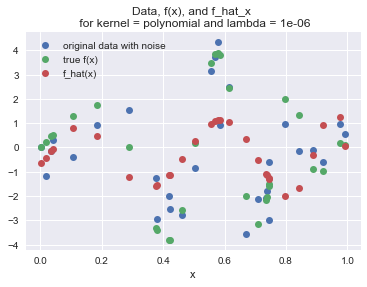

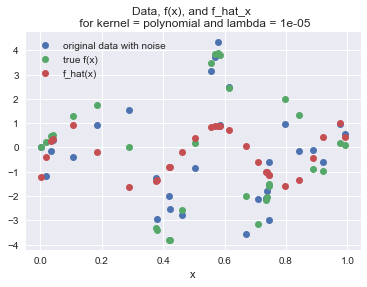

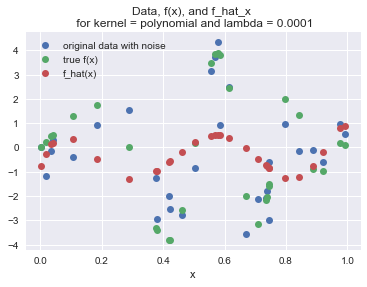

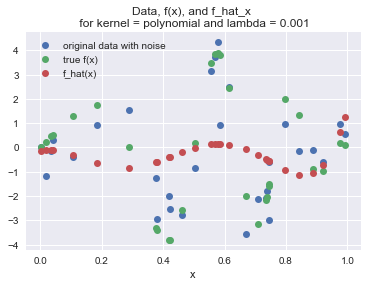

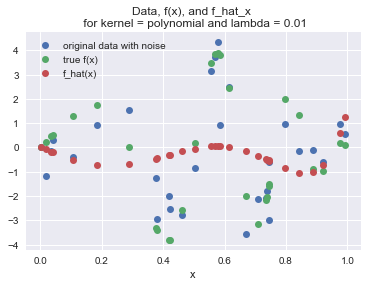

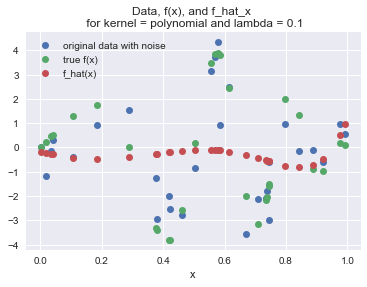

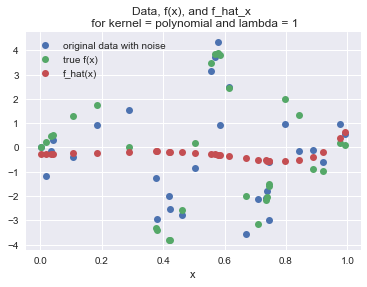

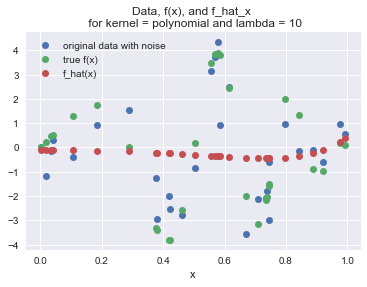

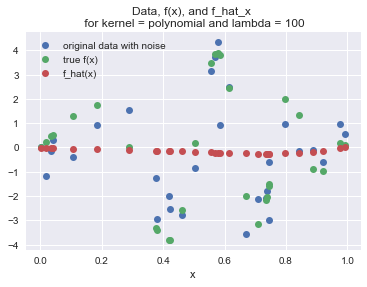

In [19]:
d_vec = np.arange(1,10)

for d in d_vec:
    
    K = make_K_mat_poly(x,d)
    
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

for lambda_val in lambda_vec:
    alpha_hat = alpha_hat_compute(K,lambda_val,y)
    f_hat = f_hat_compute(alpha_hat,K)
    plot_function(x,y,f_x,f_hat,'polynomial',lambda_val)

### rbf kernel

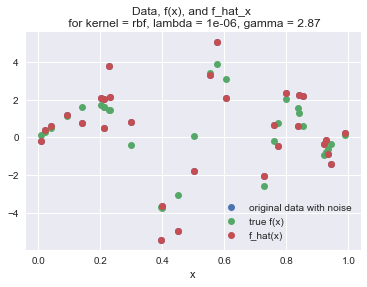

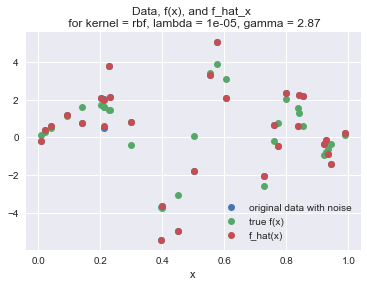

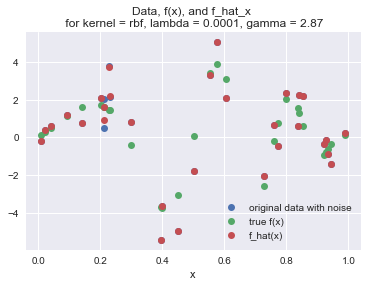

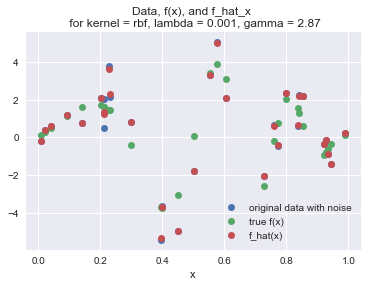

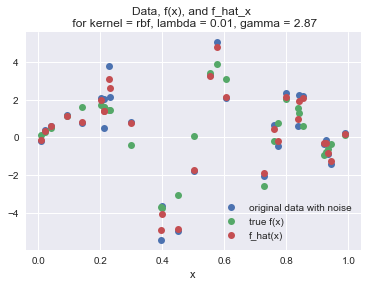

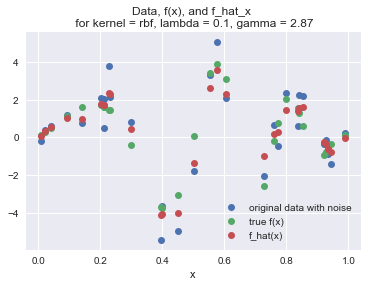

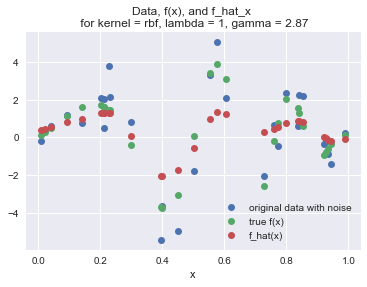

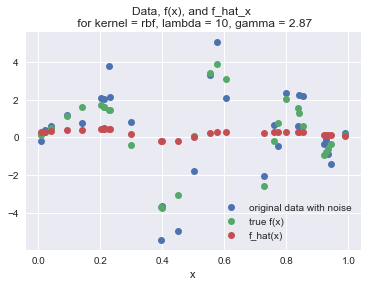

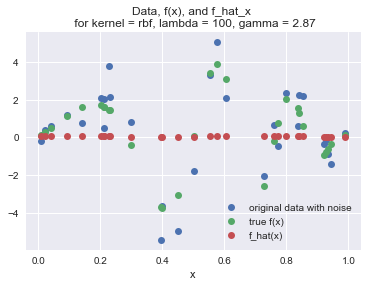

In [45]:
# choose gamma 
gamma,dist_vals = choose_gamma(x)


K = make_K_mat_rbf(x,gamma)

lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

for lambda_val in lambda_vec:
    alpha_hat = alpha_hat_compute(K,lambda_val,y)
    f_hat = f_hat_compute(alpha_hat,K)
    plot_function_rbf(x,y,f_x,f_hat,'rbf',lambda_val,gamma)

### try cross validation - polynomial

### try cross validation - rbf

In [37]:
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]


score_vec,gamma_vec = LOOCV_rbf(x,y,lambda_vec)

In [38]:
score_vec

[1.0655886883514025,
 1.0648039967008522,
 1.0609917456355389,
 1.0563183561615226,
 1.0464221307741799,
 1.0081903432599795,
 1.0937024693275899,
 1.1734271623533352,
 1.2203641012463851]

In [39]:
best_gamma = gamma_vec[np.argmin(score_vec)]
best_lambda = lambda_vec[np.argmin(score_vec)]

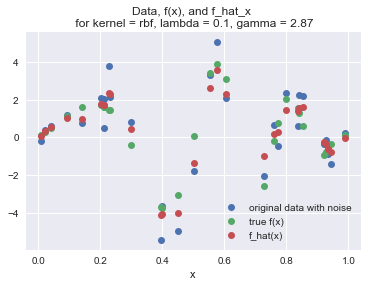

In [48]:
K = make_K_mat_rbf(x,best_gamma)


alpha_hat = alpha_hat_compute(K,best_lambda,y)
f_hat = f_hat_compute(alpha_hat,K)
plot_function_rbf(x,y,f_x,f_hat,'rbf',best_lambda,best_gamma)